<a href="https://colab.research.google.com/github/Areeff10/travelling_plan_assistant-/blob/main/travelling_plan_assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [34]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [35]:
llm=ChatGoogleGenerativeAI(model="gemini-1.5-flash",convert_system_message_to_human=True, api_key=GOOGLE_API_KEY,temperature = 0.1)

In [36]:
llm.invoke('Hello how are you').content

/usr/local/lib/python3.11/dist-packages/langchain_google_genai/chat_models.py:365: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


'I am doing well, thank you for asking!  How are you today?'

In [37]:
class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage], "the messages in the conversation"]
  city: str
  interests: List[str]
  itinerary: str
  suggestion : str

In [38]:
def input_city(state):
    print("==============================================================================================================================================")
    print("Please enter the city you want to visit for your day trip:")
    user_message = input("Your Input: ").strip()

    if not user_message:
        print("City cannot be empty. Please enter a valid city.")
        return input_city(state)

    state["city"] = user_message
    state["messages"].append(HumanMessage(content=user_message))

    return state

In [39]:
def input_interest(state):
    print("==============================================================================================================================================")
    print(f"Please enter your interests for the trip to {state['city']} (comma-separated):")
    user_message = input("Your Input: ").strip()

    if not user_message:
        print("Interests cannot be empty. Please enter at least one interest.")
        return input_interest(state)

    state["interests"] = [interest.strip() for interest in user_message.split(",")]
    state["messages"].append(HumanMessage(content=user_message))

    return state

In [40]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

In [41]:
def create_plan(state):
    print("==============================================================================================================================================")

    formatted_prompt = itinerary_prompt.format(city=state["city"], interests=", ".join(state["interests"]))
    response = llm.invoke(formatted_prompt)
    print(f"Creating a plan for {state['city']} based on interests: {', '.join(state['interests'])}")
    print("\nFinal Itinerary:")
    print(response.content)

    state["messages"].append(AIMessage(content=response.content))
    state["itinerary"] = response.content

    return state

In [42]:
suggestion_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a helpful travel assistant. Provide a list of famous places to visit and popular restaurants in {city}. "
     "Only suggest well-known attractions, landmarks, and highly-rated restaurants. Format your response as a concise, bulleted list."),
    ("human", "Give me famous places and restaurants to visit in {city}.")
])



In [43]:
def suggestion_plan(state):
    print("==============================================================================================================================================")
    formatted_prompt = suggestion_prompt.format(city=state["city"])
    response = llm.invoke(formatted_prompt)
    print(f"Creating a plan for {state['city']} based on interests: {', '.join(state['interests'])}")
    print(f"More things to do in {state['city']}")
    print("\nSuggestion:")
    print(response.content)

    state["messages"].append(AIMessage(content=response.content))
    state["suggestion"] = response.content

    return state

In [44]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_plan", create_plan)
workflow.add_node("trip_suggestion", suggestion_plan)

workflow.set_entry_point("input_city")
workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_plan")
workflow.add_edge("create_plan", "trip_suggestion")
workflow.add_edge("trip_suggestion", END)

app=workflow.compile()

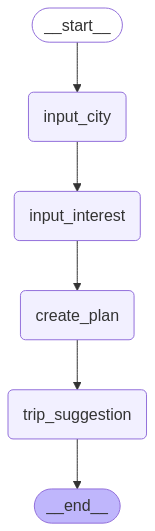

In [45]:
display(Image(app.get_graph().draw_mermaid_png()))

In [46]:
def travel_planner(user_request):
    print(f"Initial Request: {user_request}\n")

    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    for _ in app.stream(state):
        continue

In [47]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip:
Your Input: Mumbai
Please enter your interests for the trip to Mumbai (comma-separated):
Your Input: Worli Sea Link , Juhu Beach, Chowpatty Beach


/usr/local/lib/python3.11/dist-packages/langchain_google_genai/chat_models.py:365: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Creating a plan for Mumbai based on interests: Worli Sea Link, Juhu Beach, Chowpatty Beach

Final Itinerary:
## Mumbai Day Trip: Beaches & Sea Link

This itinerary focuses on Worli Sea Link, Juhu Beach, and Chowpatty Beach, prioritizing efficient travel.  Adjust timings based on your arrival and departure times.

**Morning (8:00 AM - 12:00 PM):**

* **8:00 AM - 9:00 AM:** Start your day with breakfast at a local eatery near your starting point.  Consider a quick and tasty vada pav or a South Indian breakfast.
* **9:00 AM - 10:30 AM:** Head to the Worli Sea Link. Take photos and enjoy the stunning views of the Arabian Sea and the city skyline. Consider a taxi or ride-sharing service for efficient travel.
* **10:30 AM - 12:00 PM:** Travel to Juhu Beach.  Enjoy the beach atmosphere, street food, and perhaps a quick stroll.

**Afternoon (12:00 PM - 4:00 PM):**

* **12:00 PM - 1:00 PM:** Lunch at Juhu Beach. Many stalls offer a variety of delicious street food options.
* **1:00 PM - 2:30 PM

/usr/local/lib/python3.11/dist-packages/langchain_google_genai/chat_models.py:365: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Creating a plan for Mumbai based on interests: Worli Sea Link, Juhu Beach, Chowpatty Beach
More things to do in Mumbai

Suggestion:
**Famous Places:**

* Gateway of India
* Chhatrapati Shivaji Maharaj Terminus (CST)
* Marine Drive
* Dhobi Ghat
* Mani Bhavan Gandhi Museum
* Siddhivinayak Temple
* Elephanta Caves (requires ferry)
* Kanheri Caves (Sanjay Gandhi National Park)


**Popular Restaurants:**

* **Seafood:** Gajalee (multiple locations), Mahesh Lunch Home
* **Indian Fine Dining:**  The Oberoi, The Taj Mahal Palace (various restaurants within)
* **Street Food:** Mohammed Ali Road (for Mughlai cuisine, especially during Ramadan),  various stalls around Chowpatty Beach
* **International Cuisine:**  Wasabi by Morimoto (Japanese),  Olive Bar & Kitchen (Mediterranean)


**Note:**  Restaurant popularity and ratings can change, so checking recent reviews before visiting is recommended.
